In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn

data = pd.read_csv('contest_train_binary.csv')
test = pd.read_csv('contest_test.csv')

In [ ]:
# удаляем признаки, все значения по которым одинаковые
toDrop = set()
for i in range(len(data.columns)):
  if (data.iloc[:,i].value_counts().count() == 1):
    toDrop.add(data.columns[i])
for i in range(len(test.columns)):
  if (test.iloc[:,i].value_counts().count() == 1):
    toDrop.add(test.columns[i])
for i in toDrop:
    test = test.drop(i, axis=1)
    data = data.drop(i, axis=1)

In [ ]:
# заполняем пропуски в сете и бинаризуем таргет
data = data.apply(lambda x: x.fillna(x.median()))
data['TARGET'] = data['TARGET'].astype(bool)

# заполняем пропуски в сете, переносим ID из test в новый фрейм (который будет в итоговом решении)
test = test.apply(lambda x: x.fillna(x.median()))
ans = pd.DataFrame(test['ID'])
test = test.drop('ID', axis=1)

# разбиваем, нормализируем
Y = data['TARGET']
X = data.drop(['TARGET','ID'], axis=1)
X = (X - X.mean())/X.std()
test = (test - test.mean())/test.std()

In [ ]:
# randomforest (ищем оптимумы параметров)
# параметров много, сетка большая => возможно, лучше было бы использовать RandomizedSearchCV
# также можно отдельно настраивать кросс-валидацию через cross_validation.StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier()
from sklearn.model_selection import GridSearchCV
par = {'n_estimators': range (10, 31, 10),
       'max_depth': range (1, 11, 3),
       'min_samples_leaf': range (1, 8, 3),
       'min_samples_split': range (2, 9, 3)}
grid = GridSearchCV(forest, par, scoring = 'roc_auc', cv=5)
grid.fit(X, Y)
print(grid.best_score_)
print(grid.best_params_)

0.6459197014735224
{'max_depth': 7, 'min_samples_leaf': 7, 'min_samples_split': 8, 'n_estimators': 30}


In [ ]:
# тренируем лес на оптимальных параметрах
forest = RandomForestClassifier(n_estimators=30, max_depth=7, min_samples_leaf=7, min_samples_split=8)
forest.fit(X, Y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=7, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

(-1.0, 255.0)

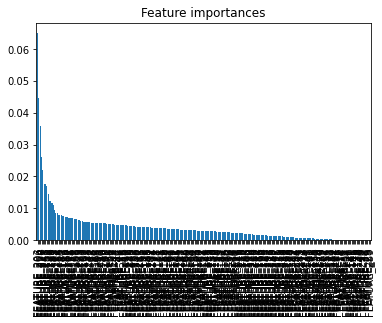

In [ ]:
# можно визуализировать значимость признаков
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
features_num = len(X.columns)
plt.figure()
plt.title("Feature importances")
plt.bar(range(features_num), importances[indices[:features_num]], align='center')
plt.xticks(range(features_num), np.array(X.columns)[indices[:features_num]], rotation=90)
plt.xlim([-1, features_num])

In [ ]:
# теперь уберём малозначимые признаки и сделаем предикт на test
toDrop = set()
for i in range(len(X.columns)):
  if importances[i] < 0.0001:
    toDrop.add(X.columns[i])
for i in toDrop:
    X = X.drop(i, axis=1)
    test = test.drop(i, axis=1)
forest.fit(X, Y)
prediction = forest.predict_proba(test)
ans['TARGET'] = prediction[:,1]
ans.to_csv('ans_forest.csv', encoding='utf-8', index=False)